In [416]:
import sys
import optuna
import datetime
import numpy as np
import pandas as pd
import tokenizers
import sklearn as sk
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
import transformers

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

sys.path.append('..')

from definitions import INPUT_DATA_DIR, PARSED_DATA_DIR, SUB_DIR, FULL_DATA_DIR, INPUT_DATA_DIR, AUTHORS_DIR

%reload_ext autoreload
%autoreload 2

In [417]:
version = {
    'lightgbm': lgb.__version__,
    'pandas': pd.__version__,
    'numpy': np.__version__,
    'scikit-learn': sk.__version__ 
}
print(version)

{'lightgbm': '3.3.2', 'pandas': '1.4.3', 'numpy': '1.23.1', 'scikit-learn': '1.1.1'}


## Данные

In [418]:
train = pd.read_json(FULL_DATA_DIR / 'full_train.json')
test = pd.read_json(FULL_DATA_DIR / 'full_test.json')

# 1. Загрузка данных

Либо можно их сразу загрузить

In [419]:
train['NAMES_FROM_TITLE'] = (
    train['ORG_TITLE'].apply(lambda x: x if isinstance(x, list) else []) + 
    train['LOC_TITLE'].apply(lambda x: x if isinstance(x, list) else []) + 
    train['PER_TITLE'].apply(lambda x: x if isinstance(x, list) else [])
)
test['NAMES_FROM_TITLE'] = (
    test['ORG_TITLE'].apply(lambda x: x if isinstance(x, list) else []) + 
    test['LOC_TITLE'].apply(lambda x: x if isinstance(x, list) else []) + 
    test['PER_TITLE'].apply(lambda x: x if isinstance(x, list) else [])
)

## 2. Предсказание для существующих

In [420]:
from src.prediction.utils import predict_for_exist
from src.constants import FeaturesConstants

In [421]:
exist_prediction = predict_for_exist(train, test)
train_and_tests_ctr_ = list(set(train['page_id']) & set(test['page_id']))

In [422]:
train_data = (
train[~(train['page_id'].isin(train_and_tests_ctr_))]
    .drop_duplicates(FeaturesConstants.target + ['document_id', 'page_id', 'ctr'])
)
train_data = train_data[train_data['full_reads_percent'] <= 100]
train_data = train_data[pd.to_datetime(train_data['publish_date']).dt.year >= 2022]
train_data = train_data[train_data['category'].isin(['5409f11ce063da9c8b588a12', '5433e5decbb20f277b20eca9', '540d5eafcbb20f2524fc0509', '5409f11ce063da9c8b588a13', '540d5ecacbb20f2524fc050a', '5409f11ce063da9c8b588a18'])]
train_data = train_data[~(train_data['document_id'].isin(['620fd6d99a7947a9ec85178cK5S1FYEqQ8KtU5-HL-9QTw', '622e2ada9a79471d2c4de0b6gHwPxacXQPmhZhBsHOOhMw']))]
train_data['publish_date'] = pd.to_datetime(train_data['publish_date'])
train_data = train_data[(train_data['views'] <= 1000000)].copy()

test_data = test[~(test['page_id'].isin(train_and_tests_ctr_))].copy()
y_data = train_data[FeaturesConstants.target].copy()

In [277]:
train_data['type'] = 'train'
test_data['type'] = 'test'
train_data['publish_date'] = pd.to_datetime(train_data['publish_date']) + datetime.timedelta(hours=3)
test_data['publish_date'] = pd.to_datetime(test_data['publish_date']) + datetime.timedelta(hours=3)

In [278]:
full = pd.concat((train_data.set_index('document_id'), test_data.set_index('document_id')), axis=0)

In [279]:
full = full.sort_values(by='publish_date')

In [280]:
full['diff_in_minutes_by_category'] = full.index.map(full.groupby(by='category')['publish_date'].diff())
full['diff_in_minutes'] = full['publish_date'].diff()

In [281]:
full['date'] = full['publish_date'].dt.date

In [282]:
train_data['diff_in_minutes_by_category'] = train_data['document_id'].map(full.groupby(by='category')['publish_date'].diff())
train_data['diff_in_minutes'] = train_data['document_id'].map(full['publish_date'].diff())

In [283]:
train_data['diff_ctr'] = train_data['document_id'].map(full.groupby(by='category')['ctr'].diff())

In [284]:
train_data['date'] = train_data['publish_date'].dt.date
train_data['count_by_date'] = train_data['date'].map(full.groupby(by='date').count()['page_id'])

In [285]:
a = []
for i in full['publish_date']:
    a.append(
        len(
            full[(i.date == full['date']) & (full['publish_date'] <= i)]
        )
    )

In [287]:
pd.Series(a, index=full.index).value_counts()

0    9874
dtype: int64

In [302]:
if True:
        from transformers import pipeline
        from tqdm import tqdm
        pipe = pipeline(model="Tatyana/rubert-base-cased-sentiment-new",
                        return_all_scores=True)
        sentiments = []
        for title in tqdm(train_data["title_preprocessed"]):
            sentiment = pipe(title)
            sentiments.append(sentiment)
        sentiment_matrix = pd.DataFrame(
            [[el["score"] for el in sentiment] for sentiment in sentiments],
            columns=["Neuteral", "Positive", "Negative"])
        train_data = pd.concat((train_data, sentiment_matrix), axis=1)

        sentiments = []
        for title in tqdm(train_data["title_preprocessed"]):
            sentiment = pipe(title)
            sentiments.append(sentiment)
        sentiment_matrix = pd.DataFrame(
            [[el["score"] for el in sentiment] for sentiment in sentiments],
            columns=["other", "misinformation", "factual"])
        train_data = pd.concat((train_data, sentiment_matrix), axis=1)

Downloading: 100%|██████████| 1.17k/1.17k [00:00<00:00, 267kB/s]
  0%|          | 22/7000 [00:04<23:54,  4.86it/s]


KeyboardInterrupt: 

In [309]:
sentiment_matrix

,Neuteral,Positive,Negative
0,0.829740,0.112881,0.057379
1,0.830100,0.113010,0.056890
2,0.819527,0.149049,0.031424
3,0.818788,0.149520,0.031692
4,0.180925,0.067888,0.751187
...,...,...,...
6902,0.806475,0.161121,0.032404
6903,0.392245,0.548340,0.059416
6904,0.829588,0.112863,0.057549
6905,0.180552,0.067741,0.751707


In [316]:
train_data

,document_id,page_id,session,ctr,publish_date,title,title_parsed,title_parsed_from_yandex,title_preprocessed,authors,...,yandex_recommendation_image_parsed,yandex_recommendation_category_parsed,views,depth,full_reads_percent,PER_TITLE,ORG_TITLE,LOC_TITLE,news_title_lemmatized,NAMES_FROM_TITLE
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,624ac09c9a7947db3d80c98e,IDE7mtH4RBqGn-8MXfGffQ,1.580,2022-04-04 10:29:44,Европейский банк развития приостановил доступ ...,Европейский банк развития приостановил доступ ...,,Европейский банк развития приостановил доступ ...,None,...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Финансы,20460,1.134,35.850,None,"[Москва, Минск]",[Европейский банк развития],"[европейский, банк, развитие, приостановить, д...","[Москва, Минск, Европейский банк развития]"
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,620f6b899a7947701cf489e1,KtVJsteHStO5oditt3Uvzw,1.853,2022-02-18 10:00:39,Кремль назвал регулярным процессом учебные зап...,Кремль назвал регулярным процессом учебные зап...,Дмитрий Песков: учебные запуски баллистических...,Кремль назвал регулярным процессом учебные зап...,"[54244e01cbb20f03076b236d, 5878a2ec9a7947e531f...",...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Политика,19038,1.142,38.355,None,[Кремль],None,"[кремль, назвать, регулярный, процесс, учебный...",[Кремль]
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,620730cf9a7947ab96a44e27,hk7puWJwSziw0m3sfTkKWA,NaN,2022-02-12 04:24:02,Госсекретарь Швеции заявила о нежелании вступа...,Госсекретарь Швеции заявила о нежелании вступа...,,Госсекретарь Швеции заявила о нежелании вступа...,None,...,None,Военная операция на Украине,51151,1.185,36.424,None,"[Швеция, Украина]",[НАТО],"[госсекретарь, швеция, заявить, о, нежелание, ...","[Швеция, Украина, НАТО]"
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,6262a5889a79470b78c9ca30,7UKY2SSZTjCcjhwBzxw37w,NaN,2022-04-22 13:24:55,Песков назвал прагматичной выдачу лицензии Газ...,Песков назвал прагматичной выдачу лицензии Газ...,,Песков назвал прагматичной выдачу лицензии Газ...,None,...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Политика,3782,1.053,30.169,None,None,[Газпромбанк],"[песков, назвать, прагматичный, выдача, лиценз...",[Газпромбанк]
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,626678929a79477ca0101568,wuMYES90REuV5YhrN75IXg,NaN,2022-04-25 10:42:23,В Хабаровске задержали главу филиала РАНХиГС п...,В Хабаровске задержали главу филиала РАНХиГС п...,,В Хабаровске задержали главу филиала РАНХиГС п...,None,...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Общество,3065,1.063,34.617,None,[Хабаровск],[РАНХиГС],"[в, хабаровск, задержать, глава, филиал, ранхи...","[Хабаровск, РАНХиГС]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,61fd479c9a79478481836947,51RC_1i5QlGuv7B2FzwTjw,2.354,2022-02-04 16:19:09,"Открытие Олимпиады, новые китайские контракты ...","Открытие Олимпиады, новые китайские контракты ...",,"Открытие Олимпиады, новые китайские контракты ...",[5878a2ec9a7947e531faf52c],...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Общество,21738,1.188,28.448,None,[Россия],None,"[открытие, олимпиада, ,, новый, китайский, кон...",[Россия]
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,628a8f1c9a79478c64a7dae4,50tIkSGVSf2O8XQgk_uaHQ,4.112,2022-05-22 20:07:46,Саудовская Аравия выразила надежду на соглашен...,Саудовская Аравия выразила надежду на соглашен...,,Саудовская Аравия выразила надежду на соглашен...,"[60fa94ed9a7947b7152c986a, 5e4663219a794736af9...",...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Бизнес,8377,1.056,38.045,None,"[Саудовская Аравия, Россия]",[ОПЕК+],"[саудовский, аравия, выразить, надежда, на, со...","[Саудовская Аравия, Россия, ОПЕК+]"
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,6244cf5e9a79479099346b26,tKlqoxQYSmij0ZBrGzebug,5.125,2022-03-30 21:59:02,Брюс Уиллис завершит актерскую карьеру из-за б...,Брюс Уиллис завершит актерскую кар

In [319]:
sentiment_matrix.index = train_data.index

In [321]:
train_data = pd.concat([train_data, sentiment_matrix], axis=1)

In [263]:
train_data['ctr'] = train_data['ctr'].fillna(0)

In [264]:
for i in [1, 5, 10, 30, 60, 120, 360]:
    train_data[f'fufuf_{i}_mean'] = train_data['publish_date'].map(full.set_index('publish_date')['ctr'].rolling(f'{i}Min').mean().to_dict())
    train_data[f'fufuf_{i}_max'] = train_data['publish_date'].map(full.set_index('publish_date')['ctr'].rolling(f'{i}Min').max().to_dict())
    train_data[f'fufuf_{i}_min'] = train_data['publish_date'].map(full.set_index('publish_date')['ctr'].rolling(f'{i}Min').min().to_dict())

In [265]:

for i in [1, 5, 10, 30, 60, 120, 360]:
    train_data[f'fufufe_{i}_mean'] = train_data['publish_date'].map(
        full.set_index('publish_date')['title_preprocessed'].apply(lambda x: len(x.split())).rolling(
            f'{i}Min').mean().to_dict())
    train_data[f'fufufe_{i}_max'] = train_data['publish_date'].map(
        full.set_index('publish_date')['title_preprocessed'].apply(lambda x: len(x.split())).rolling(
            f'{i}Min').max().to_dict())
    train_data[f'fufufe_{i}_min'] = train_data['publish_date'].map(
        full.set_index('publish_date')['title_preprocessed'].apply(lambda x: len(x.split())).rolling(
            f'{i}Min').min().to_dict())

In [266]:
for i in [1, 5, 10, 30, 60, 120, 360]:
    train_data[f'fufufef_{i}_mean'] = train_data['publish_date'].map(
        full.set_index('publish_date')['NAMES_FROM_TITLE'].apply(lambda x: len(x)).rolling(
            f'{i}Min').mean().to_dict())
    train_data[f'fufufef_{i}_max'] = train_data['publish_date'].map(
        full.set_index('publish_date')['NAMES_FROM_TITLE'].apply(lambda x: len(x)).rolling(
            f'{i}Min').max().to_dict())
    train_data[f'fufufef_{i}_min'] = train_data['publish_date'].map(
        full.set_index('publish_date')['NAMES_FROM_TITLE'].apply(lambda x: len(x)).rolling(
            f'{i}Min').min().to_dict())

In [267]:
train_data = train_data[train_data['document_id'] != '6236462b9a7947544365254d0664WRQsQRGOIbsqUT0LSw'].copy()
y_data = train_data[FeaturesConstants.target].copy()

`622628279a7947c6c137810dE9yxvjhnSZquRAMkc5jHrg` - test - не забыть

# Features

## 3. Feature Generation

## 3.1 Identifier

- `page_id`: `624ac09c9a7947db3d80c98e`

## 3.2 Date

- `publish_date`: `2022-04-04 10:29:44` + `timedelta(hours=3)`

## 3.3 Title

- `title` - title новости от организаторов, (**текст**)
- `title_parsed` - спарсенный title новости, (**текст**)
- `optional[title_parsed_from_yandex]` - заголовок статьи в `yandex`, (**текст**)
- `title_preprocessed` - удалены `category`

## 3.4 Category

- `category` - категория новости, **hash**
- `category_parsed` - спарсенная категория новости, **текст**
- `category_from_title` - категория, выделенная из текста, **Optional[текст]**

## 3.5 Ctr

- `ctr` - показатель кликабельности, **Optional[float64]**

## 3.6 Tags

- `tags` - таги, закодированные от организаторов, **Optional[hash]**
- `tags_parsed` - спарсенные тэги, **Optional[текст]**

## 3.7 Auhtors

- `authors` - авторы новости от организаторов, **Optional[hash]**
- `authors_parsed` - авторы новости **Optional[текст]**

## 3.8 Text

- `news_text_parsed` - текст новости, полный, **текст** 
- `news_text_overview_parsed` - некоторая выжимка новости, **текст**
- `news_amount_of_paragraphs_parsed` - количество параграфов в тексте, **int64**
- `news_amount_of_inline_items_parsed` - количество ссылок на другие новости в тексте новости, **int64**
- `news_inline_titles_parsed` - заголовки на другие статьи в тексте новости, **Optional[текст]**
- `news_has_image_parsed` - есть ли в новости картинка, **int64**
- `news_image_title_parsed` - подпись к изображению, если есть, **Optional[текст]**

## 3.9. Features Selector Transformer

In [449]:
from src.transformers.base import Compose
from src.transformers.feature_generation import (
    DatetimeTransformer,
    TitleTransformer,
    CategoryTransformer,
    CTRTransformer,
    TagsTransformer,
    AuthorsTransformer,
    TextTransformer,
    NatashaTextTransformer,
    FeatureSelector,
    TfidfVectorTransformer,
    CountTfIdfVectorizer,
    MultiLabelTransformer
)


# 4. Model Fitting

In [426]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import optuna

from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)

import warnings
warnings.filterwarnings("ignore")

In [427]:
def plotImp(
    model,
    X, 
    num=10, 
    fig_size = (40, 20)
):
    feature_imp = pd.DataFrame(
        {'Value': model.feature_importances_,
         'Feature': X.columns}
    )
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    sns.barplot(
        x="Value", 
        y="Feature", 
        data=feature_imp.sort_values(by="Value", ascending=False)[0:num],
        ax=ax
    )
    plt.show()
    


In [428]:
kfold = KFold(n_splits=3, shuffle=True, random_state=239)

In [429]:
train_data

,document_id,page_id,session,ctr,publish_date,title,title_parsed,title_parsed_from_yandex,title_preprocessed,authors,...,yandex_recommendation_image_parsed,yandex_recommendation_category_parsed,views,depth,full_reads_percent,PER_TITLE,ORG_TITLE,LOC_TITLE,news_title_lemmatized,NAMES_FROM_TITLE
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,624ac09c9a7947db3d80c98e,IDE7mtH4RBqGn-8MXfGffQ,1.580,2022-04-04 10:29:44,Европейский банк развития приостановил доступ ...,Европейский банк развития приостановил доступ ...,,Европейский банк развития приостановил доступ ...,None,...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Финансы,20460,1.134,35.850,None,"[Москва, Минск]",[Европейский банк развития],"[европейский, банк, развитие, приостановить, д...","[Москва, Минск, Европейский банк развития]"
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,620f6b899a7947701cf489e1,KtVJsteHStO5oditt3Uvzw,1.853,2022-02-18 10:00:39,Кремль назвал регулярным процессом учебные зап...,Кремль назвал регулярным процессом учебные зап...,Дмитрий Песков: учебные запуски баллистических...,Кремль назвал регулярным процессом учебные зап...,"[54244e01cbb20f03076b236d, 5878a2ec9a7947e531f...",...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Политика,19038,1.142,38.355,None,[Кремль],None,"[кремль, назвать, регулярный, процесс, учебный...",[Кремль]
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,620730cf9a7947ab96a44e27,hk7puWJwSziw0m3sfTkKWA,NaN,2022-02-12 04:24:02,Госсекретарь Швеции заявила о нежелании вступа...,Госсекретарь Швеции заявила о нежелании вступа...,,Госсекретарь Швеции заявила о нежелании вступа...,None,...,None,Военная операция на Украине,51151,1.185,36.424,None,"[Швеция, Украина]",[НАТО],"[госсекретарь, швеция, заявить, о, нежелание, ...","[Швеция, Украина, НАТО]"
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,6262a5889a79470b78c9ca30,7UKY2SSZTjCcjhwBzxw37w,NaN,2022-04-22 13:24:55,Песков назвал прагматичной выдачу лицензии Газ...,Песков назвал прагматичной выдачу лицензии Газ...,,Песков назвал прагматичной выдачу лицензии Газ...,None,...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Политика,3782,1.053,30.169,None,None,[Газпромбанк],"[песков, назвать, прагматичный, выдача, лиценз...",[Газпромбанк]
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,626678929a79477ca0101568,wuMYES90REuV5YhrN75IXg,NaN,2022-04-25 10:42:23,В Хабаровске задержали главу филиала РАНХиГС п...,В Хабаровске задержали главу филиала РАНХиГС п...,,В Хабаровске задержали главу филиала РАНХиГС п...,None,...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Общество,3065,1.063,34.617,None,[Хабаровск],[РАНХиГС],"[в, хабаровск, задержать, глава, филиал, ранхи...","[Хабаровск, РАНХиГС]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,61fd479c9a79478481836947,51RC_1i5QlGuv7B2FzwTjw,2.354,2022-02-04 16:19:09,"Открытие Олимпиады, новые китайские контракты ...","Открытие Олимпиады, новые китайские контракты ...",,"Открытие Олимпиады, новые китайские контракты ...",[5878a2ec9a7947e531faf52c],...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Общество,21738,1.188,28.448,None,[Россия],None,"[открытие, олимпиада, ,, новый, китайский, кон...",[Россия]
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,628a8f1c9a79478c64a7dae4,50tIkSGVSf2O8XQgk_uaHQ,4.112,2022-05-22 20:07:46,Саудовская Аравия выразила надежду на соглашен...,Саудовская Аравия выразила надежду на соглашен...,,Саудовская Аравия выразила надежду на соглашен...,"[60fa94ed9a7947b7152c986a, 5e4663219a794736af9...",...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Бизнес,8377,1.056,38.045,None,"[Саудовская Аравия, Россия]",[ОПЕК+],"[саудовский, аравия, выразить, надежда, на, со...","[Саудовская Аравия, Россия, ОПЕК+]"
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,6244cf5e9a79479099346b26,tKlqoxQYSmij0ZBrGzebug,5.125,2022-03-30 21:59:02,Брюс Уиллис завершит актерскую карьеру из-за б...,Брюс Уиллис завершит актерскую кар

In [391]:
test_data

,document_id,page_id,session,ctr,publish_date,title,title_parsed,title_parsed_from_yandex,title_preprocessed,authors,...,twitter_card_parsed,twitter_image_parsed,vk_image_parsed,yandex_recommendation_image_parsed,yandex_recommendation_category_parsed,PER_TITLE,ORG_TITLE,LOC_TITLE,news_title_lemmatized,NAMES_FROM_TITLE
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,61f9569a9a794794245a82ab,J0AvX96vTAaQCiWVbzoMdw,NaN,2022-02-01 17:02:44,«Крайне провокационная тема»: как Россия и США...,«Крайне провокационная тема»: как Россия и США...,WP: между постпредами России и США в ООН произ...,«Крайне провокационная тема»: как Россия и США...,None,...,summary_large_image,https://s0.rbk.ru/v6_top_pics/media/img/5/46/7...,https://s0.rbk.ru/v6_top_pics/media/img/6/37/7...,None,Военная операция на Украине,None,"[Россия, США]","[Совбез, ООН]","[«, крайне, провокационный, тема, », :, как, р...","[Россия, США, Совбез, ООН]"
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,628c22b89a79470e553f594b,QS5CqzXYRnmDdR2LaSreEw,1.598,2022-05-24 00:50:55,Власти Херсонской области пообещали сделать ру...,Власти Херсонской области пообещали сделать ру...,,Власти Херсонской области пообещали сделать ру...,None,...,summary_large_image,https://s0.rbk.ru/v6_top_pics/media/img/1/39/7...,https://s0.rbk.ru/v6_top_pics/media/img/3/55/7...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Военная операция на Украине,None,[Херсонская область],None,"[власть, херсонский, область, пообещать, сдела...",[Херсонская область]
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,627cb3249a7947ebdd752865,XVsoyrUOT8OJJg2_finJhw,2.006,2022-05-12 07:11:51,Премьер и президент Финляндии призвали срочно ...,Премьер и президент Финляндии призвали срочно ...,,Премьер и президент Финляндии призвали срочно ...,None,...,summary_large_image,https://s0.rbk.ru/v6_top_pics/media/img/9/61/7...,https://s0.rbk.ru/v6_top_pics/media/img/7/19/7...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Политика,None,[Финляндия],[НАТО],"[премьер, и, президент, финляндия, призвать, с...","[Финляндия, НАТО]"
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,628618629a7947d4927eb812,upfii3whSSuMXCqcqF8VbQ,NaN,2022-05-19 11:54:35,В Госдуму внесли проект о временных администра...,Миронов внес проект о временных администрациях...,,В Госдуму внесли проект о временных администра...,None,...,summary_large_image,https://s0.rbk.ru/v6_top_pics/media/img/5/65/7...,https://s0.rbk.ru/v6_top_pics/media/img/9/63/7...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Военная операция на Украине,None,[Россия],[Госдума],"[в, госдума, внести, проект, о, временной, адм...","[Россия, Госдума]"
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,620e76109a7947235623695b,5hzCiIHdSYKQIr8WAM18bw,9.136,2022-02-17 16:28:55,Блинкен заявил в ООН о готовности России начат...,Блинкен заявил в ООН о готовности России начат...,Блинкен: российские войска готовятся начать вт...,Блинкен заявил в ООН о готовности России начат...,[604f2c199a79478ec0029eae],...,summary_large_image,https://s0.rbk.ru/v6_top_pics/media/img/3/01/7...,https://s0.rbk.ru/v6_top_pics/media/img/1/48/7...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Военная операция на Украине,None,[Россия],[ООН],"[блинкен, заявить, в, оон, о, готовность, росс...","[Россия, ООН]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,623ba6bc9a79470214cb9418x4OZQ1IjTb27nPAgv5wAZg,623ba6bc9a79470214cb9418,x4OZQ1IjTb27nPAgv5wAZg,1.788,2022-03-23 23:28:34,Суд не стал публиковать решение о запрете Face...,Суд не стал публиковать решение о запрете Face...,,Суд не стал публиковать решение о запрете Face...,[5bfd1d039a794755995093f8],...,summary_large_image,https://s0.rbk.ru/v6_top_pics/media/img/3/03/7...,https://s0.rbk.ru/v6_top_pics/media/img/3/36/7...,https://s0.rbk.ru/v6_top_pics/resized/1200xH/m...,Технологии и медиа,None,None,"[Facebook, Instagram]","[суд, не, стать, публиковать, решение, о, запр...","[Facebook, Instagram]"
2996,624fda1f9a79471a9bd10

In [388]:
pd.concat([train_data, train_dd], axis=1)

,document_id,page_id,session,ctr,publish_date,title,title_parsed,title_parsed_from_yandex,title_preprocessed,authors,...,names_from_title_цб,names_from_title_швеция,names_from_title_шойгу,names_from_title_шолец,names_from_title_шольц,names_from_title_эрдоган,names_from_title_южная,names_from_title_южная осетия,names_from_title_яндекс,names_from_title_япония
0,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,624ac09c9a7947db3d80c98e,IDE7mtH4RBqGn-8MXfGffQ,1.580,2022-04-04 10:29:44,Европейский банк развития приостановил доступ ...,Европейский банк развития приостановил доступ ...,,Европейский банк развития приостановил доступ ...,None,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,620f6b899a7947701cf489e1,KtVJsteHStO5oditt3Uvzw,1.853,2022-02-18 10:00:39,Кремль назвал регулярным процессом учебные зап...,Кремль назвал регулярным процессом учебные зап...,Дмитрий Песков: учебные запуски баллистических...,Кремль назвал регулярным процессом учебные зап...,"[54244e01cbb20f03076b236d, 5878a2ec9a7947e531f...",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,620730cf9a7947ab96a44e27,hk7puWJwSziw0m3sfTkKWA,NaN,2022-02-12 04:24:02,Госсекретарь Швеции заявила о нежелании вступа...,Госсекретарь Швеции заявила о нежелании вступа...,,Госсекретарь Швеции заявила о нежелании вступа...,None,...,0.0,0.574208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,6262a5889a79470b78c9ca30,7UKY2SSZTjCcjhwBzxw37w,NaN,2022-04-22 13:24:55,Песков назвал прагматичной выдачу лицензии Газ...,Песков назвал прагматичной выдачу лицензии Газ...,,Песков назвал прагматичной выдачу лицензии Газ...,None,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,626678929a79477ca0101568,wuMYES90REuV5YhrN75IXg,NaN,2022-04-25 10:42:23,В Хабаровске задержали главу филиала РАНХиГС п...,В Хабаровске задержали главу филиала РАНХиГС п...,,В Хабаровске задержали главу филиала РАНХиГС п...,None,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,61fd479c9a79478481836947,51RC_1i5QlGuv7B2FzwTjw,2.354,2022-02-04 16:19:09,"Открытие Олимпиады, новые китайские контракты ...","Открытие Олимпиады, новые китайские контракты ...",,"Открытие Олимпиады, новые китайские контракты ...",[5878a2ec9a7947e531faf52c],...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6996,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,628a8f1c9a79478c64a7dae4,50tIkSGVSf2O8XQgk_uaHQ,4.112,2022-05-22 20:07:46,Саудовская Аравия выразила надежду на соглашен...,Саудовская Аравия выразила надежду на соглашен...,,Саудовская Аравия выразила надежду на соглашен...,"[60fa94ed9a7947b7152c986a, 5e4663219a794736af9...",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6997,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,6244cf5e9a79479099346b26,tKlqoxQYSmij0ZBrGzebug,5.125,2022-03-30 21:59:02,Брюс Уиллис завершит актерскую карьеру из-за б...,Брюс Уиллис завершит актерскую карьеру из-за б...,,Брюс Уиллис завершит актерскую карьеру из-за б...,None,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6998,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,627303699a794749b8116abc,12JX_3ZDTDu2XHF3k2eJVg,NaN,2022-05-04 23:15:48,Экс-посол Франции назвал болезненным для Европ...,Экс-посол Франции назвал болезненным для Европ...,,Экс-посол Франции назвал болезненным для Европ...,None,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [393]:
train_features

,ctr,authors,category,news_amount_of_paragraphs_parsed,news_amount_of_inline_items_parsed,news_has_image_parsed,hour,month,day,dayofweek,...,names_from_title_цб,names_from_title_швеция,names_from_title_шойгу,names_from_title_шолец,names_from_title_шольц,names_from_title_эрдоган,names_from_title_южная,names_from_title_южная осетия,names_from_title_яндекс,names_from_title_япония
0,1.580,0.0,5409f11ce063da9c8b588a18,9.0,1.0,1.0,13.0,4.0,4.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.853,37.0,5409f11ce063da9c8b588a12,6.0,1.0,1.0,13.0,2.0,18.0,4.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,0.0,5409f11ce063da9c8b588a12,6.0,2.0,0.0,7.0,2.0,12.0,5.0,...,0.0,0.574208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,0.0,5409f11ce063da9c8b588a12,8.0,1.0,1.0,16.0,4.0,22.0,4.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,0.0,5433e5decbb20f277b20eca9,9.0,1.0,1.0,13.0,4.0,25.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
        # tfidf = TfidfVectorTransformer(
        #     col='NAMES_FROM_TITLE',
        #     tfidf_vectorizer=TfidfVectorizer(
        #         ngram_range=(1, 4),
        #         min_df=1,
        #         max_features=128
        #     )
        # )
        # tfidf.fit(train_data)
        # train_dd = tfidf.transform(train_data)
        # test_dd = tfidf.transform(test_data)
        # train_features = pd.concat([train_features, train_dd], axis=1)
        # test_features = pd.concat([test_features, test_dd], axis=1)    #

In [400]:
from transformers import BertTokenizer, BertModel

In [401]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

Downloading: 100%|██████████| 1.57M/1.57M [00:02<00:00, 651kB/s] 
Downloading: 100%|██████████| 112/112 [00:00<00:00, 24.9kB/s]
Downloading: 100%|██████████| 24.0/24.0 [00:00<00:00, 6.86kB/s]
Downloading: 100%|██████████| 642/642 [00:00<00:00, 143kB/s]


In [402]:
model_rubert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')

Downloading: 100%|██████████| 681M/681M [00:59<00:00, 11.9MB/s] 
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [403]:
input_train_title_tokenized = [
    tokenizer.encode(sent, max_length=62, pad_to_max_length=True, return_tensors='pt')
    for sent in train_data['title_preprocessed']
]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [406]:
import torch
def get_pooler_out(model, inpt3, batch_size=32):
    model.eval()

    pooler_output = torch.empty([0, 768])


    for b in range(len(inpt3)//batch_size + 1):
        print(b)
        up_to = b*batch_size + batch_size
        if len(inpt3) < up_to:
            up_to = len(inpt3)
        input_ids = torch.cat(inpt3[b*batch_size:up_to])

        with torch.no_grad():
            embedding = model.forward(input_ids=input_ids, output_hidden_states=True)['hidden_states'][-1][:,0]
            pooler_output = torch.cat([pooler_output, embedding],0)


    return pooler_output

In [407]:
vectors = get_pooler_out(model_rubert, input_train_title_tokenized, batch_size=32)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215


In [408]:
vec_list = vectors.tolist()
vec_df = pd.DataFrame(vec_list)
vec_df = pd.DataFrame(vec_df[[0]])
vec_df = vec_df.rename(columns={0 : 'CLS_1'})
train_data['cls_token'] = vec_df['CLS_1'].values

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [411]:
train_data = train_data.drop('cls_token', axis=1)

In [434]:
    train_features = FeatureGenerator(
        data=train_data,
        mode='train'
    )

In [435]:
train_features

,ctr,authors,category,news_amount_of_paragraphs_parsed,news_amount_of_inline_items_parsed,news_has_image_parsed,hour,month,day,dayofweek,feb_24,is_na_ctr,num_words_text,num_words_text_diff,num_words_title
0,1.580,0,5409f11ce063da9c8b588a18,9,1,1,13,4,4,0,39,False,226,0.300000,10
1,1.853,37,5409f11ce063da9c8b588a12,6,1,1,13,2,18,4,-6,False,230,0.125000,8
2,NaN,0,5409f11ce063da9c8b588a12,6,2,0,7,2,12,5,-12,True,180,0.300000,10
3,NaN,0,5409f11ce063da9c8b588a12,8,1,1,16,4,22,4,57,True,249,0.100000,10
4,NaN,0,5433e5decbb20f277b20eca9,9,1,1,13,4,25,0,60,True,354,0.200000,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,2.354,128,5433e5decbb20f277b20eca9,1,1,1,19,2,4,4,-20,False,0,0.111111,9
6996,4.112,416,540d5eafcbb20f2524fc0509,7,1,1,23,5,22,6,87,False,270,0.300000,10
6997,5.125,0,5433e5decbb20f277b20eca9,5,0,0,0,3,31,3,35,False,119,0.142857,7
6998,NaN,0,5409f11ce063da9c8b588a13,7,1,1,2,5,5,3,70,True,232,0.200000,10


In [450]:
FeatureGenerator = Compose(
        transforms=[
            DatetimeTransformer(target_variable='views'),
            TitleTransformer(),
            CTRTransformer(),
            TagsTransformer(target_variable='views'),
            AuthorsTransformer(target_variable='views'),
            TextTransformer(),
            NatashaTextTransformer(),
            CategoryTransformer(),
            FeatureSelector()
        ]
    )

In [462]:
train_features = FeatureGenerator(
        data=train_data,
        mode='train'
)
test_features = FeatureGenerator(
    data=test_data,
    mode='test'
)

In [463]:
        tfidf = TfidfVectorTransformer(
            col='NAMES_FROM_TITLE',
            tfidf_vectorizer=TfidfVectorizer(
                ngram_range=(1, 4),
                min_df=1,
                max_features=128
            )
        )
        tfidf.fit(train_data)
        train_td = tfidf.transform(train_data)
        test_td = tfidf.transform(test_data)
        train_features = pd.concat([train_features, train_td], axis=1)
        test_features = pd.concat([test_features, test_td], axis=1)

True
(6907, 37) (6907, 128)
True
(2967, 34) (2967, 128)


In [466]:
for i in train_features.dtypes:
    print(i)

float64
category
category
int64
int64
int64
int64
int64
int64
int64
int64
bool
float64
float64
float64
float64
float64
float64
float64
float64
float64
int64
float64
int64
object
object
object
float64
datetime64[ns]
object
object
object
object
object
object
object
object
object
object
object
object
object
int64
int64
object
int64
object
object
object
object
object
object
object
int64
float64
float64
object
object
object
object
object
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float64, 0]
Sparse[float

In [469]:
train_features.iloc[:, 20:]

,std_authors_ctr,num_words_text,num_words_text_diff,num_words_title,document_id,page_id,session,ctr,publish_date,title,...,names_from_title_цб,names_from_title_швеция,names_from_title_шойгу,names_from_title_шолец,names_from_title_шольц,names_from_title_эрдоган,names_from_title_южная,names_from_title_южная осетия,names_from_title_яндекс,names_from_title_япония
0,2.958562,226,0.300000,10,624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,624ac09c9a7947db3d80c98e,IDE7mtH4RBqGn-8MXfGffQ,1.580,2022-04-04 10:29:44,Европейский банк развития приостановил доступ ...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,230,0.125000,8,620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,620f6b899a7947701cf489e1,KtVJsteHStO5oditt3Uvzw,1.853,2022-02-18 10:00:39,Кремль назвал регулярным процессом учебные зап...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.958562,180,0.300000,10,620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,620730cf9a7947ab96a44e27,hk7puWJwSziw0m3sfTkKWA,NaN,2022-02-12 04:24:02,Госсекретарь Швеции заявила о нежелании вступа...,...,0.0,0.574208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.958562,249,0.100000,10,6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,6262a5889a79470b78c9ca30,7UKY2SSZTjCcjhwBzxw37w,NaN,2022-04-22 13:24:55,Песков назвал прагматичной выдачу лицензии Газ...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.958562,354,0.200000,10,626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,626678929a79477ca0101568,wuMYES90REuV5YhrN75IXg,NaN,2022-04-25 10:42:23,В Хабаровске задержали главу филиала РАНХиГС п...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,2.469239,0,0.111111,9,61fd479c9a7947848183694751RC_1i5QlGuv7B2FzwTjw,61fd479c9a79478481836947,51RC_1i5QlGuv7B2FzwTjw,2.354,2022-02-04 16:19:09,"Открытие Олимпиады, новые китайские контракты ...",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6996,NaN,270,0.300000,10,628a8f1c9a79478c64a7dae450tIkSGVSf2O8XQgk_uaHQ,628a8f1c9a79478c64a7dae4,50tIkSGVSf2O8XQgk_uaHQ,4.112,2022-05-22 20:07:46,Саудовская Аравия выразила надежду на соглашен...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6997,2.958562,119,0.142857,7,6244cf5e9a79479099346b26tKlqoxQYSmij0ZBrGzebug,6244cf5e9a79479099346b26,tKlqoxQYSmij0ZBrGzebug,5.125,2022-03-30 21:59:02,Брюс Уиллис завершит актерскую карьеру из-за б...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6998,2.958562,232,0.200000,10,627303699a794749b8116abc12JX_3ZDTDu2XHF3k2eJVg,627303699a794749b8116abc,12JX_3ZDTDu2XHF3k2eJVg,NaN,2022-05-04 23:15:48,Экс-посол Франции назвал болезненным для Европ...,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


True
(6907, 37) (6907, 128)
True
(2967, 34) (2967, 128)
views:  0.7091144979974041


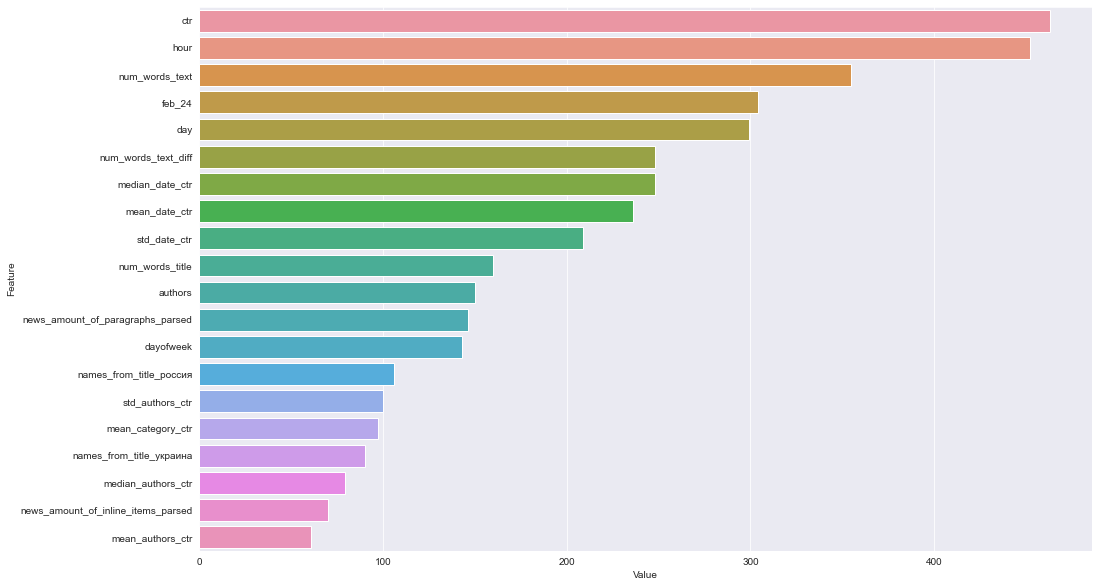

depth:  0.8390469753388962


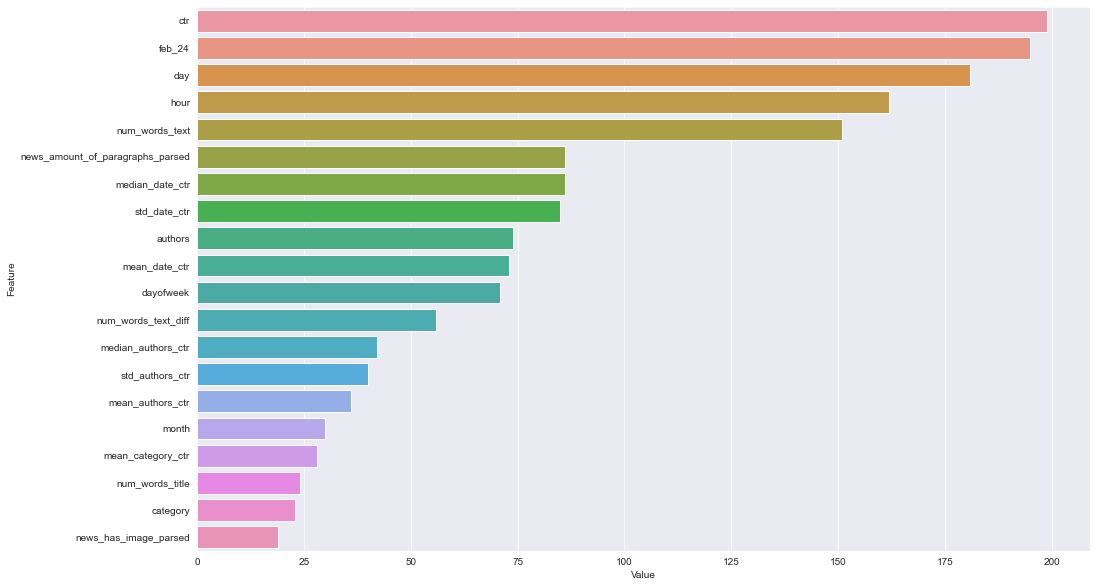

full_reads_percent:  0.5600379212912708


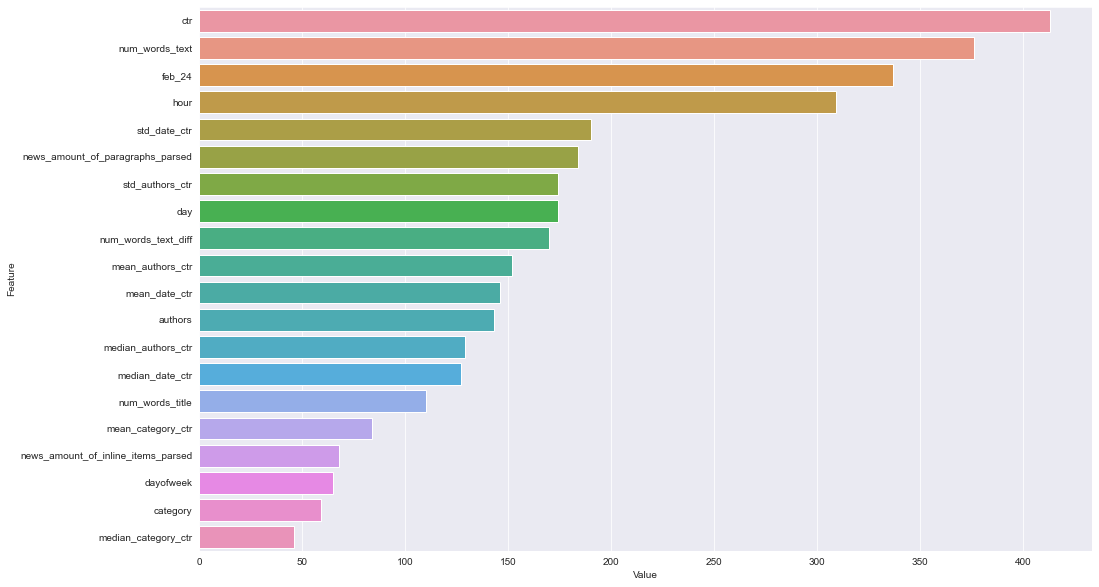

Final score: 0.7033712681880118, median: 0.7027402917247529


In [490]:
result_dict = {
    'views': {'r2': [], 'trees': [], 'prediction': []},
    'full_reads_percent': {'r2': [], 'trees': [], 'prediction': []},
    'depth': {'r2': [], 'trees': [], 'prediction': []}
}
for target_variable in FeaturesConstants.target:
    FeatureGenerator = Compose(
        transforms=[
            DatetimeTransformer(
                target_variable=target_variable
            ),
            TitleTransformer(),
            CTRTransformer(
                eps=(
                    0.1 
                    if target_variable == 'views' 
                    else 0.5
                )
            ),
            TagsTransformer(target_variable=target_variable),
            AuthorsTransformer(
                target_variable=target_variable
            ),
            TextTransformer(
                use_text_transformer=(
                    target_variable 
                    if target_variable == 'full_reads_percent' 
                    else None
                )
            ),
            NatashaTextTransformer(),
            CategoryTransformer(),
            FeatureSelector()
        ]
    )
    train_features = FeatureGenerator(
        data=train_data,
        mode='train'
    )
    test_features = FeatureGenerator(
        data=test_data,
        mode='test'
    )
    if target_variable == 'views':
        tfidf = TfidfVectorTransformer(
            col='NAMES_FROM_TITLE',
            tfidf_vectorizer=TfidfVectorizer(
                ngram_range=(1, 4),
                min_df=1,
                max_features=128
            )
        )
        tfidf.fit(train_data)
        train_td = tfidf.transform(train_data)
        test_td = tfidf.transform(test_data)
        train_features = pd.concat([train_features, train_td], axis=1)
        test_features = pd.concat([test_features, test_td], axis=1)

    # if target_variable != 'd':
    #     for i in ['PER_TITLE', 'ORG_TITLE', 'LOC_TITLE', 'authors_parsed']:
    #         tfidf = CountTfIdfVectorizer(
    #             col=i,
    #             count_vectorizer=CountVectorizer(
    #                 ngram_range=(1, 2)
    #             )
    #         )
    #         tfidf.fit(train_data)
    #         train_features[f'{i}_popularity'] = tfidf.transform(train_data)
    #         test_features[f'{i}_popularity'] = tfidf.transform(test_data)
        # tfidf = TfidfVectorTransformer(
        #     col='NAMES_FROM_TITLE',
        #     tfidf_vectorizer=TfidfVectorizer(
        #         ngram_range=(1, 4),
        #         min_df=1,
        #         max_features=128
        #     )
        # )
        # tfidf.fit(train_data)
        # train_dd = tfidf.transform(train_data)
        # test_dd = tfidf.transform(test_data)
        # train_features = pd.concat([train_features, train_dd], axis=1)
        # test_features = pd.concat([test_features, test_dd], axis=1)

    if target_variable == 'full_reads_percent':
        m = MultiLabelTransformer(col='authors_parsed')
        m.fit(train_data)
        train_author = m.transform(train_data)
        test_author = m.transform(test_data)
        train_features = pd.concat(
            [train_features, train_author],
            axis=1
        )
        test_features = pd.concat(
            [test_features, test_author],
            axis=1
        )

    # if target_variable != 'full_reads_percent':
    #     tfidf = TfidfVectorTransformer(
    #         col='tags_parsed',
    #         tfidf_vectorizer=TfidfVectorizer(
    #             ngram_range=(1, 4),
    #             max_features=256,
    #             min_df=5
    #         )
    #     )
    #     tfidf.fit(train_data)
    #     train_dd = tfidf.transform(train_data)
    #     test_dd = tfidf.transform(test_data)
    #     train_features = pd.concat([train_features, train_dd], axis=1)
    #     test_features = pd.concat([test_features, test_dd], axis=1)
    #
    #     cec = CountTfIdfVectorizer(
    #         col='authors_parsed',
    #         count_vectorizer=CountVectorizer(
    #             ngram_range=(2, 2),
    #             min_df=2
    #         )
    #     )
    #     cec.fit(td)
    #     train_features['author_popularity'] = cec.transform(td)
    #     test_features['author_popularity'] = cec.transform(test_data)

    for train_index, val_index in kfold.split(train_features):

        X_train, X_valid = (
            train_features.reset_index(drop=True).iloc[train_index, :], 
            train_features.reset_index(drop=True).iloc[val_index, :]
        )
        y_train, y_valid = (
            y_data[target_variable].reset_index(drop=True).iloc[train_index],
            y_data[target_variable].reset_index(drop=True).iloc[val_index]
        )
        if target_variable == 'views':
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
        elif target_variable == 'depth':
            y_train = np.log(np.log(y_train))
            y_valid = np.log(np.log(y_valid))
        else:
            y_train = np.log(y_train)
            y_valid = np.log(y_valid)
                    
        lgbm_regressor = lgb.LGBMRegressor(
            objective='regression',
            random_state=33,
            early_stopping_round=100, 
            n_estimators=500,
            subsample=1,
            colsample_bytree=0.75,
            learning_rate=0.08,
            max_depth=-1,
            verbose=-1
        )
        lgbm_regressor.fit(
            X_train, 
            y_train, 
            eval_set=[(X_valid, y_valid)],
            eval_metric='r2',
            verbose=-1
        )

        y_pred = lgbm_regressor.predict(X_valid)
        r2 = r2_score(y_valid, y_pred)
        result_dict[target_variable]['r2'].append(r2)
        result_dict[target_variable]['trees'].append(lgbm_regressor.booster_.trees_to_dataframe())

        
        pro = lgbm_regressor.predict(test_features)
        if target_variable == 'views':
            pro = np.exp(pro)
        elif target_variable == 'depth':
            pro = np.exp(np.exp(pro))
        else:
            pro = np.exp(pro)
        assert len(pro[pro < 0]) == 0
        result_dict[target_variable]['prediction'].append(pro)
    print(f'{target_variable}: ', np.mean(result_dict[target_variable]['r2']))
    plotImp(lgbm_regressor, train_features, num=20, fig_size=(16, 10))

full_score = (
    np.mean(result_dict['views']['r2']) * 0.4 + 
    np.mean(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.mean(result_dict['depth']['r2']) * 0.3
)
full_score_2 = (
    np.median(result_dict['views']['r2']) * 0.4 + 
    np.median(result_dict['full_reads_percent']['r2']) * 0.3 + 
    np.median(result_dict['depth']['r2']) * 0.3
)
print(f'Final score: {full_score}, median: {full_score_2}')

# Sub4 - best

In [491]:
sub = pd.DataFrame(
    {
        'document_id': test_data['document_id'].values,
        'views': pd.DataFrame(result_dict['views']['prediction']).T.median(axis=1),
        'depth': pd.DataFrame(result_dict['depth']['prediction']).T.median(axis=1),
        'full_reads_percent': pd.DataFrame(result_dict['full_reads_percent']['prediction']).T.median(axis=1),
    },
)
sub.index = test_data.index

In [492]:
sub_full = pd.concat((sub, exist_prediction)).sort_index()

In [493]:
ss = pd.read_csv('../sub/sample_solution.csv')

In [494]:
sub_full_2 = pd.DataFrame(ss['document_id'])

In [495]:
views = []
full_reads_percent = []
depth = []
for j, i in sub_full_2.iterrows():
    dummy = sub_full[sub_full['document_id'] == i['document_id']]
    views.append(dummy['views'].values[0])
    full_reads_percent.append(dummy['full_reads_percent'].values[0])
    depth.append(dummy['depth'].values[0])

In [496]:
sub_full_2['views'] = views
sub_full_2['full_reads_percent'] = full_reads_percent
sub_full_2['depth'] = depth

In [497]:
sub_full_2.to_csv(SUB_DIR / 'good_night.csv', index=False)